In [82]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from numpy import diff
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
import lal
from pycbc import waveform, types
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize

In [83]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
#from matplotlib import gridspec


#plt.style.reload_library()
#plt.style.use(['science','notebook'])


#plt.rc('xtick', labelsize=20) 
#plt.rc('ytick', labelsize=20) 

#plt.rc('font', weight='bold')
#plt.rc('axes', labelsize=16)
#plt.rc('legend', fontsize=10)

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


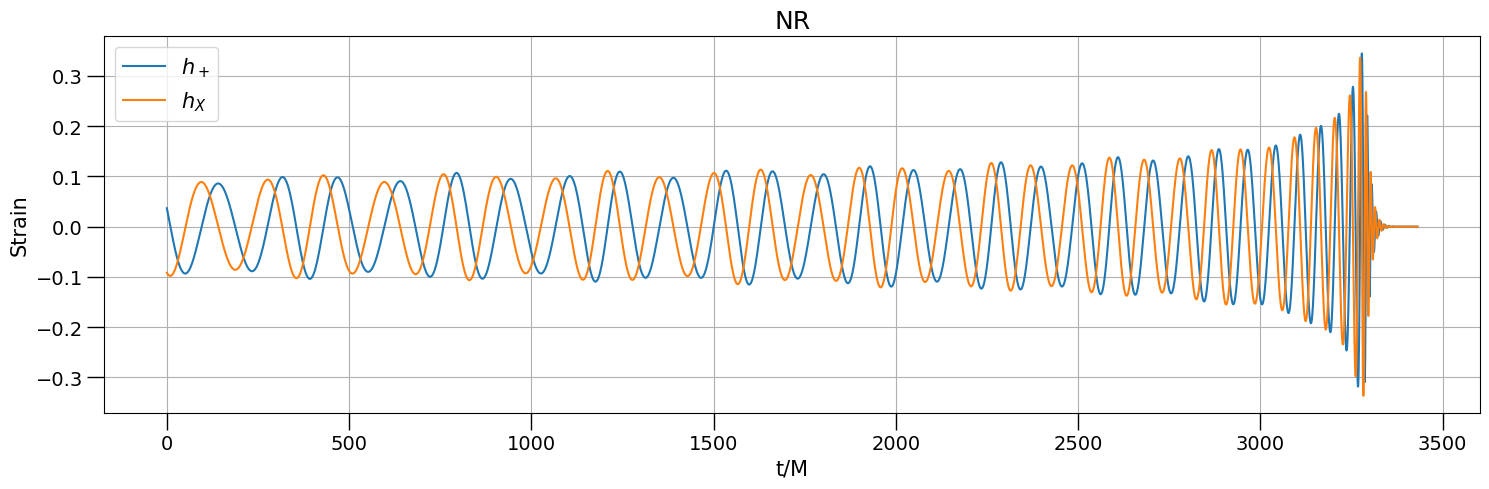

In [84]:
#NR
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

In [85]:
#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

In [86]:
print(len(tVec_SI),len(hpVec_SI),len(hcVec_SI))

13578 13578 13578


9.5367431640625e-07
13578 17721


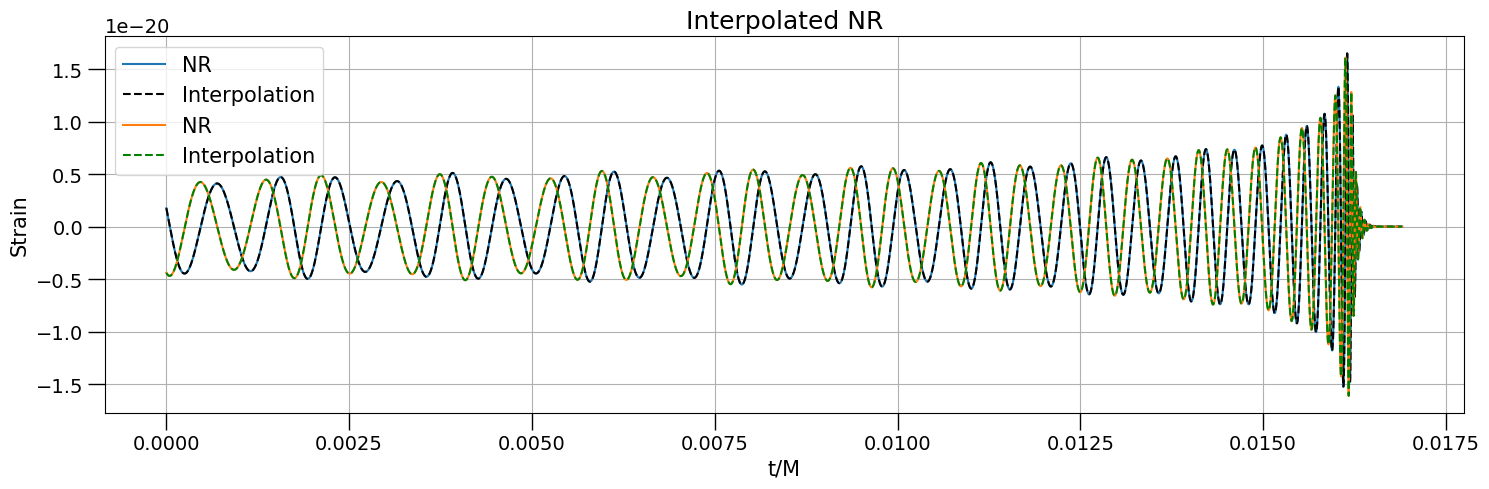

In [87]:
#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR + 1j*hcVec_NR)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


plt.figure(figsize=(15,5))
plt.plot(tVec_SI,hpVec_SI,label='NR') 
plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

plt.plot(tVec_SI,hcVec_SI,label='NR') 
plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

plt.title("Interpolated NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(t),len(hpVec_NR))

In [88]:
#PN

phiC=phase_NR[mergIdx_NR]                 
tC_NR=max(hpVec_NR.sample_times)
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma= 0.577215664901

%run GW_functions.ipynb
mt=M                        #Total mass of eccentricTD wf 
m_sun=MSUN_SI                #Mass of sun in seconds
conv=mt*MTSUN_SI              #total mass (needed to convert PN time t to t/M)

#Formula to compute f from a given x
def freq(u,mass):
    return math.pow(u,3.0/2.0)/(2 * MTSUN_SI * mass * lal.PI / 2)   # f = x^(3/2) * c^3 / (G * M * 2pi/mp), mp = 2 for 22 mode
                                                                    # for 22 mode of EccTD, mp=2
f_low=freq(xlow,mt)            #Lower frequency of EccTD wf which is in our hands
f_ref=freq(xref,mt)            #Ref frequency of EccTD wf

####################################################

#Calculating ecc at xlow for generating EccTD wf-->eccentricity evolution Eq. (4.17a,b) Moore et. al.(2016)

%run GW_functions.ipynb         #Notebook with all PN evolution equations
x=xlow                         #x=point where eccentricity is required
v=math.sqrt(x)
vref=math.sqrt(xref)
xie=v**3
xiref=vref**3

#Gives e at xie with b.c.--> e=eref when xie=xiref

e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)


In [89]:
print(e,e0)
print(f_low)  ## 22 mode frequency
print(f_ref)  ## 22 mode frequency
## PyCBC generates 22 mode only, so frequency for 22 mode required

0.20487488954085048 0.169
399.0000000000001
1327.3715049596763


In [90]:
hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                         delta_t=delta_t_common, 
                         f_lower=f_low, 
                         eccentricity=e0,
                         distance=1)
print(hpVec_PN)
print(hcVec_PN)

[-3.16885013e-22 -3.23225816e-22 -3.29562556e-22 ... -6.64247933e-21
 -6.65349609e-21 -6.66019524e-21]
[1.82861838e-21 1.82750865e-21 1.82637597e-21 ... 3.64286512e-22
 1.94600796e-22 2.44340456e-23]


0.01689910888671875
[-0.28087425 -0.2808733  -0.28087234 ...  0.01689625  0.0168972
  0.01689816]
312238


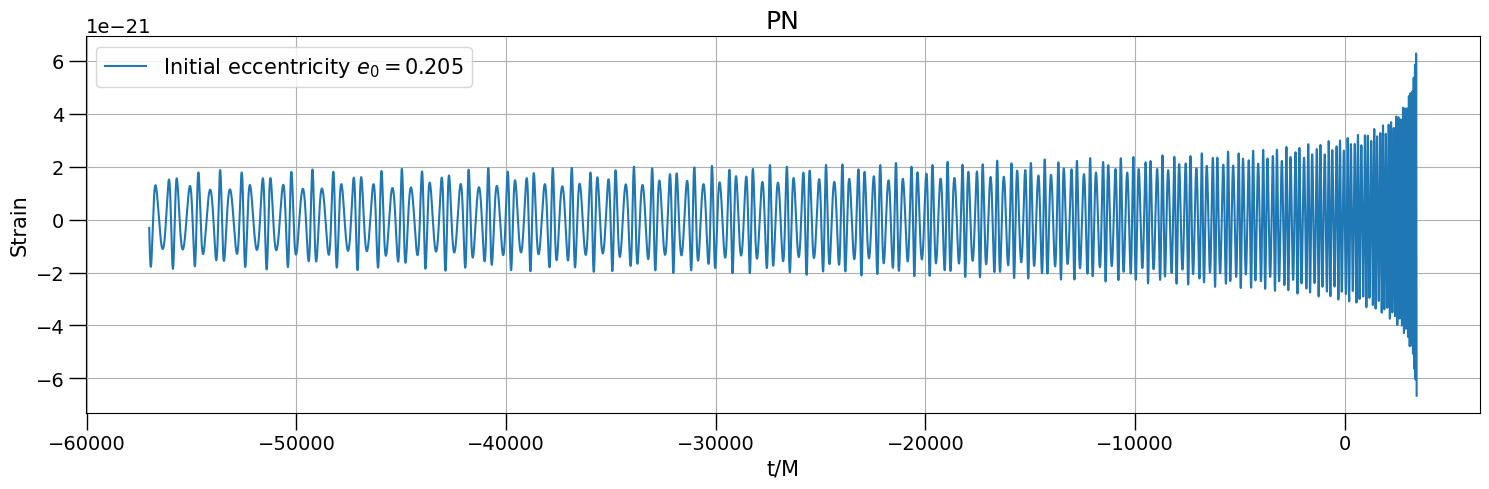

In [91]:
plt.figure(figsize=(15,5))
print(tC_NR)
tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
print(tVec_PN_shifted)
plt.plot(tVec_PN_shifted/conv,hpVec_PN,label='Initial eccentricity $e_0=%1.3f$' %e)
plt.title("PN",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(hpVec_PN))

In [92]:
## eccentricTD from PyCBC is 22 mode, hence the modetopolfac value is for 22 mode
phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))
print(phase_EccTD)

[0.00000000e+00 3.46854846e-03 6.93709579e-03 ... 1.18258326e+03
 1.18260881e+03 1.18263438e+03]


In [93]:
## PyCBC generates only the 2,2 mode. So modetopolfac for 22 mode works for the PyCBC strain
tVec_PN_GM=tVec_PN_shifted/conv
tVec_NR_GM=tVec_NR/conv
hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))

In [94]:
tC_NR=tC_NR/conv
tC_NR

print(tVec_PN_GM)
print(hpVec_PN_GM)
print(hcVec_PN_GM)
print(tC_NR)

[-57024.61960781 -57024.42598765 -57024.2323675  ...   3430.36825815
   3430.5618783    3430.75549845]
[-0.00662189 -0.00675439 -0.00688681 ... -0.13880673 -0.13903694
 -0.13917694]
[0.03821232 0.03818913 0.03816546 ... 0.00761243 0.00406654 0.00051059]
3430.9490767681923


In [95]:
#%run GW_functions.ipynb 

#tVec_PN=hpVec_PN.sample_times/conv
tVec_PN=tVec_PN_GM
tC_NR=tC_NR

#print(tVec_PN)
#print(tC_NR)

xi_ref=xref**(3/2)
v_ref=xi_ref**(1/3)
#input initial params
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
#e0=(eref*(xi_ref/xi0)**(19/18))*(epsilon(xi0, eta)/epsilon(xi_ref, eta))
l0=mean_anomaly(xi_ref, xi0, lref, eta,e0)
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)
print(theta,theta0,e0,M,eta)

[0.37268617 0.37268632 0.37268647 ... 1.57949316 1.6616177  1.81203143] 0.3726861692142768 0.169 1 0.2222222222222222


In [96]:
print(theta,theta0)
#print(tVec_PN)
print(fVec)

[0.37268617 0.37268632 0.37268647 ... 1.57949316 1.6616177  1.81203143] 0.3726861692142768
[ 1.96166242e-03  1.96166495e-03  1.96166749e-03 ... -3.99134059e+00
 -6.60462830e+00 -1.56760225e+01]


In [97]:
####xiVec=(2*np.pi*M*fVec/mp)  ### probable relation for higher modes

xiVec=(np.pi*M*fVec)   ### might be for 22 mode only
#print('xiVec:', xiVec)
xVec=xiVec**(2/3)
print('xVec:', xVec)
vVec=xiVec**(1/3)
print(vVec)

xVec: [0.03361368 0.03361371 0.03361374 ...        nan        nan        nan]
[0.18334035 0.18334043 0.1833405  ...        nan        nan        nan]


In [98]:
for i in range(0,len(xVec)):
    if xVec[i]>=0.1025:
        print(i)
        break
#lst = i
lst = 100105
print(xVec[100100])
print(xVec[lst])


310850
0.037238253322358875
0.037238482334513545


In [99]:
print(xiVec)

[ 6.16274424e-03  6.16275221e-03  6.16276018e-03 ... -1.25391663e+01
 -2.07490517e+01 -4.92476772e+01]


In [100]:
#selct +ve frequencies
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=xiVec[plotIdx2]
xVec=xVec[plotIdx2]
vVec=vVec[plotIdx2]
maxPNidx=len(xVec)
print(plotIdx2,fVec,xiVec,xVec,vVec,maxPNidx)

(array([     0,      1,      2, ..., 311991, 311992, 311993]),) [1.96166242e-03 1.96166495e-03 1.96166749e-03 ... 2.24923492e-04
 1.46238824e-04 6.67641779e-05] [0.00616274 0.00616275 0.00616276 ... 0.00070662 0.00045942 0.00020975] [0.03361368 0.03361371 0.03361374 ... 0.00793335 0.00595399 0.00353017] [0.18334035 0.18334043 0.1833405  ... 0.08906934 0.07716213 0.05941523] 311994


In [101]:
len(xVec), len(phase_EccTD)

(311994, 312238)

In [102]:


j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs22=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs22.append(abs(hlm))

100%|██████████████████████████████████| 311994/311994 [05:30<00:00, 943.80it/s]


In [103]:
#print(hlm_abs44[:maxPNidx])

In [104]:
mp, j
NRamp = abs(hpVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp22= NRamp
NRomega22= omega_NR
tNR22= tVec_NR_GM

PNamp22= hlm_abs22[:maxPNidx]
PNomega22= omega_PN[:maxPNidx]
tPN22= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(2,1)$

In [105]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 1
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_21 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_21 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_21 + 1j*hcVec_NR_21)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))




(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [106]:

j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs21=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_21(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs21.append(abs(hlm))

100%|█████████████████████████████████| 311994/311994 [02:17<00:00, 2275.18it/s]


In [107]:
mp, j
NRamp = abs(hpVec_NR_21/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_21/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp21= NRamp
NRomega21= omega_NR
tNR21= tVec_NR_GM

PNamp21= hlm_abs21[:maxPNidx]
PNomega21= omega_PN[:maxPNidx]
tPN21= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(3,3)$

In [108]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 3 #modes
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_33 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_33 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_33 + 1j*hcVec_NR_33)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))



(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [109]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs33=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs33.append(abs(hlm))

100%|█████████████████████████████████| 311994/311994 [02:44<00:00, 1896.82it/s]


In [110]:
mp, j
NRamp = abs(hpVec_NR_33/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_33/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp33= NRamp
NRomega33= omega_NR
tNR33= tVec_NR_GM

PNamp33= hlm_abs33[:maxPNidx]
PNomega33= omega_PN[:maxPNidx]
tPN33= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(3,2)$

In [111]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 3 #modes
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_32 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_32 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_32 + 1j*hcVec_NR_32)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [112]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs32=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_32(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs32.append(abs(hlm))

100%|█████████████████████████████████| 311994/311994 [01:40<00:00, 3109.17it/s]


In [113]:
mp, j
NRamp = abs(hpVec_NR_32/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_32/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp32= NRamp
NRomega32= omega_NR
tNR32= tVec_NR_GM

PNamp32= hlm_abs32[:maxPNidx]
PNomega32= omega_PN[:maxPNidx]
tPN32= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(4,4)$

In [114]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 4 #modes
mp = 4
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_44 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_44 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_44 + 1j*hcVec_NR_44)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [115]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs44=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs44.append(abs(hlm))

100%|█████████████████████████████████| 311994/311994 [02:41<00:00, 1934.92it/s]


In [116]:
mp, j
NRamp = abs(hpVec_NR_44/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_44/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp44= NRamp
NRomega44= omega_NR
tNR44= tVec_NR_GM

PNamp44= hlm_abs44[:maxPNidx]
PNomega44= omega_PN[:maxPNidx]
tPN44= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(5,5)$

In [117]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 4 #modes
mp = 3
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_43 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_43 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_43 + 1j*hcVec_NR_43)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [118]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs43=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_43(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs43.append(abs(hlm))

100%|█████████████████████████████████| 311994/311994 [02:45<00:00, 1885.68it/s]


In [119]:
mp, j
NRamp = abs(hpVec_NR_43/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_43/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp43= NRamp
NRomega43= omega_NR
tNR43= tVec_NR_GM

PNamp43= hlm_abs43[:maxPNidx]
PNomega43= omega_PN[:maxPNidx]
tPN43= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

# $(l,m)=(5,5)$

In [120]:
simulation = '/home/pratul/Downloads/rhOverM_Asymptotic_GeometricUnits_CoM.h5' #change simulations as needed
tref = 640.0 #check meta-data of NR simulations for tref
sims = simulation.split('_')[0]
lp = 5 #modes
mp = 5
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)


#with h5py.File('1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5', 'r') as hdf:
#    temp=hdf['OutermostExtraction.dir']['Y_l5_m5.dat']
#    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

#setting t=0 at merger
#mergIdx_NR=np.argmax(amp)
#x1_peakatzero=x1-x1[mergIdx]

#plt.figure(figsize=(15,5))
#plt.plot(x1,y1,label='$h_+$')
#plt.plot(x1,z1,label='$h_X$')
#plt.plot(x1,amp,'k--')
#plt.title("NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#plt.savefig('1364_20mode.pdf')

#parameters change with simulations
q=2
eref=0.05                                  
cl=lref=2.132
e0=0.169 #0.12
eta=neu=nu=q/(1+q)**2 
xref=0.075   
xlow=0.03365489193007444 #0.045
G=c=d=1
M = 1
M2=M/(1+q)
M1=M2*q
#modetopolfac=4*(5/(64*np.pi))**(1/2)  ## change according to mode

hl2m2pVec=y1
hl2m2cVec=z1

tVec=x1
hpVec=hl2m2pVec #* modetopolfac
hcVec= hl2m2cVec #* modetopolfac
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI
hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI
hcVec_SI=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI

#delta_t_NR=np.max(abs(np.diff(tVec_SI)))   #max or min not the mean (t/M = 10, in secs it is 5*10**-5)

delta_t_NR = 1/2**20

#print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI
#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
hpVec_NR_55 = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR_55 = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

## phase and frequency
phase_NR=np.unwrap(np.angle(hpVec_NR_55 + 1j*hcVec_NR_55)*2)/2
omega_NR = -(M*MTSUN_SI/delta_t_common)*(np.gradient(phase_NR))


#plt.figure(figsize=(15,5))
#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')

#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(tVec_NR,hc_NR_int,'g--',label='Interpolation')

#plt.title("Interpolated NR",fontsize=18)
#plt.ylabel("Strain", fontsize=15)
#plt.xlabel("t/M", fontsize=15)
#plt.grid()
#plt.legend(loc=2,prop={'size': 15})
#print(len(t),len(hpVec_NR))

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578


In [121]:
j=0
omega=[]
phasePN = []
hlm_real=[]
hlm_imag=[]
hlm_abs55=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    l=mean_anomaly(xie, xi0, l0, eta,e0) 
    
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    phasePN.append(mp*psi/2)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm_real.append(hlm.real)
    hlm_imag.append(hlm.imag)
    hlm_abs55.append(abs(hlm))

100%|█████████████████████████████████| 311994/311994 [01:56<00:00, 2674.45it/s]


In [122]:
mp, j
NRamp = abs(hpVec_NR_55/(G_SI*M_SI/D_SI/C_SI/C_SI) + 1j*hcVec_NR_55/(G_SI*M_SI/D_SI/C_SI/C_SI))
hpPN = np.array(hlm_real)
hcPN = np.array(hlm_imag)
#phase_PN = np.unwrap(np.angle(hpPN - 1j*hcPN)*2)/2
phase_PN = phasePN
omega_PN = (M*MTSUN_SI/delta_t_common)*(np.gradient(phase_PN))
#print(type(hlm_imag))
NRamp55= NRamp
NRomega55= omega_NR
tNR55= tVec_NR_GM

PNamp55= hlm_abs55[:maxPNidx]
PNomega55= omega_PN[:maxPNidx]
tPN55= tVec_PN_GM[:maxPNidx]
#print(PNamp55[:lst])

In [123]:
lst = 311900 #100050

In [124]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

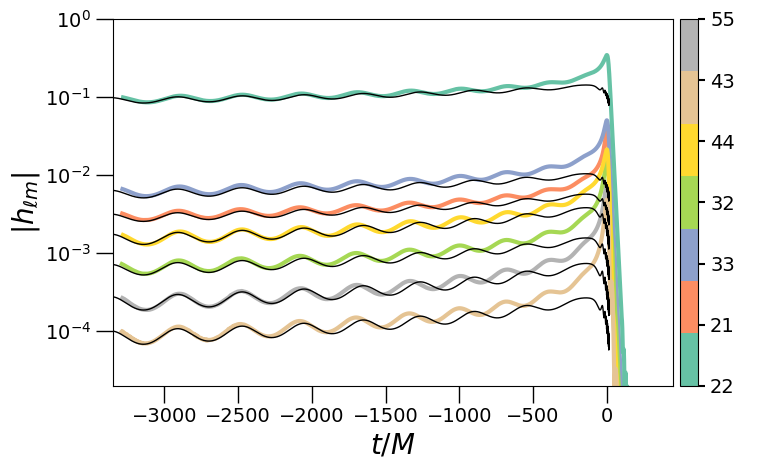

In [125]:
#plt.figure(figsize=(12,7))
plt.figure(figsize=(8.0,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)
lw = [3.0,1]
plt.plot(tNR55- tNR55[np.argmax(NRamp55)] , NRamp55,linewidth = lw[0],c=cmap(6))
plt.plot(tNR21 - tNR21[np.argmax(NRamp21)] , NRamp21,linewidth = lw[0],c=cmap(1))
plt.plot(tNR33 - tNR33[np.argmax(NRamp33)] , NRamp33,linewidth = lw[0],c=cmap(2))
plt.plot(tNR32 - tNR32[np.argmax(NRamp32)] , NRamp32,linewidth = lw[0],c=cmap(3))
#plt.plot(tNR31 - tNR31[0] , NRamp31,linewidth = lw[0],c=cmap(4))
plt.plot(tNR44 - tNR44[np.argmax(NRamp44)] , NRamp44,linewidth = lw[0],c=cmap(4))
plt.plot(tNR43 - tNR43[np.argmax(NRamp43)] , NRamp43,linewidth = lw[0],c=cmap(5))
#plt.plot(tNR42 - tNR42[0] , NRamp42,linewidth = lw[0],c=cmap(7))
plt.plot(tNR22-tNR22[np.argmax(NRamp22)], NRamp22,linewidth = lw[0],c=cmap(0))
#plt.plot(tNR54 - tNR54[0] , NRamp54,linewidth = lw[0],c=cmap(7))
#plt.plot(tNR53 - tNR53[0] , NRamp53,linewidth = lw[0],c=cmap(10))
#plt.clim(21, 55)

#plt.colorbar(label="Mode", ticks = [21,22,32,33,43,44,54,55], orientation="vertical")
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_label(label=' ',size=15)
cbar.set_ticklabels(["22", "21", "33", "32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


plt.plot(tPN55[:lst]-tPN55[np.argmax(PNamp55)] + 32,PNamp55[:lst],label='PN',linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN21[:lst]-tPN21[np.argmax(PNamp21)] + 32,PNamp21[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN33[:lst]-tPN33[np.argmax(PNamp33)] + 32,PNamp33[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN32[:lst]-tPN32[np.argmax(PNamp32)] + 32,PNamp32[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN31[:lst]-tPN31[np.argmax(PNamp31)]-50 + tNR31[np.argmax(NRamp31)],PNamp31[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN44[:lst]-tPN44[np.argmax(PNamp44)] + 32,PNamp44[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN43[:lst]-tPN43[np.argmax(PNamp43)] + 32,PNamp43[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN42[:lst]-tPN42[np.argmax(PNamp42)]-10 + tNR42[np.argmax(NRamp42)],PNamp42[:lst],linewidth = lw[1],color='black',linestyle='-')
plt.plot(tPN22[:lst]-tPN22[np.argmax(PNamp22)] + 32,PNamp22[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN54[:lst]-tPN54[np.argmax(PNamp54)] + tNR54[np.argmax(NRamp54)],PNamp54[:lst],linewidth = lw[1],color='black',linestyle='-')
#plt.plot(tPN53[:lst]-tPN53[np.argmax(PNamp53)]-10 + tNR53[np.argmax(NRamp53)],PNamp53[:lst],linewidth = lw[1],color='black',linestyle='-')

#print(tPN55[:lst]-tPN55[np.argmax(PNamp55)])

#np.savetxt('PN22.txt',np.c_[tPN55[:lst]-tPN55[np.argmax(PNamp55)] + 32 + tNR55[np.argmax(NRamp55)],PNamp55[:lst]])
#np.savetxt('NR22.txt',np.c_[tNR55 - tNR55[0],NRamp55])
#np.savetxt('formodel55.txt',np.c_[tPN55[:lst]-tPN55[np.argmax(PNamp55)] + 32,PNamp55[:lst]])


plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)

plt.yscale('log')
#plt.title("PN-NR",fontsize=18)
#plt.ylabel(r"$\mathcal{A}_{\ell m}$", fontsize=30)
plt.ylabel(r"$|h_{\ell m}|$", fontsize=20,labelpad=2)
plt.xlabel(r"$t/M$", fontsize=20)
plt.minorticks_off()

#plt.grid()
#plt.legend(loc=2,ncol=2,prop={'size': 15},bbox_to_anchor=(1, 0.5))
#plt.legend(loc=2,ncol=2,prop={'size': 30})


from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]##)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=2)   
    
cmap_labels = ["NR","PN"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
#plt.legend(handles=cmap_handles, 
           #labels=cmap_labels, 
           #handler_map=handler_map,prop={'size': 30}, ncol = 2, loc=2)



#plt.savefig('amp_1364_new.pdf')

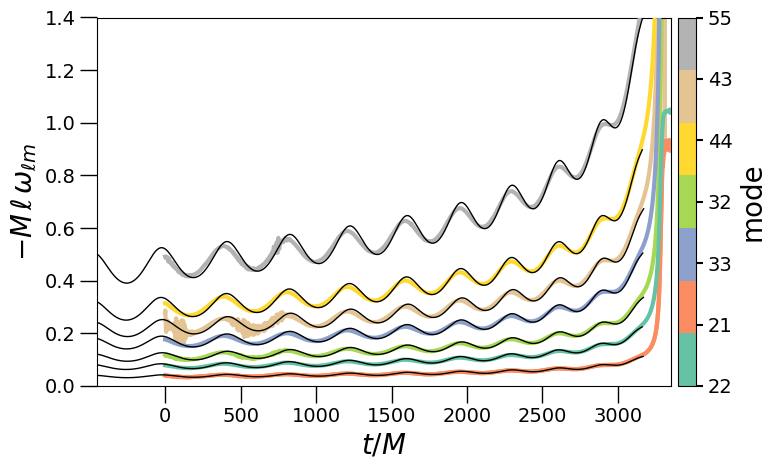

In [129]:
#plt.figure(figsize=(12,7))
plt.figure(figsize=(8,4.8))

N = 7
cmap = plt.get_cmap('Set2', N)
#colors = pl.cm.jet(np.linspace(0,1,N))
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


plt.plot(tNR22 - tNR22[0], NRomega22*2,linewidth = 3.0,c=cmap(0),zorder=4)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR21 - tNR21[0], NRomega21*2,linewidth = 3.0,c=cmap(1),zorder=3)
plt.plot(tNR33 - tNR33[0], NRomega33*3,linewidth = 3.0,c=cmap(2),zorder=4)
plt.plot(tNR32 - tNR32[0], NRomega32*3,linewidth = 3.0,c=cmap(3),zorder=2)
#plt.plot(tNR31 - tNR31[0], NRomega31*3,linewidth = 3.0,c=cmap(4),zorder=2)
plt.plot(tNR44 - tNR44[0], NRomega44*4,linewidth = 3.0,c=cmap(4),zorder=4)
plt.plot(tNR43 - tNR43[0], NRomega43*4,linewidth = 3.0,c=cmap(5),zorder=1)  #[4100:]
#plt.plot(tNR42 - tNR42[0], NRomega42*4,linewidth = 3.0,c=cmap(7),zorder=1)
plt.plot(tNR55 - tNR55[0], NRomega55*5,linewidth = 3.0,c=cmap(6),zorder=4)
#plt.plot(tNR54 - tNR54[0], NRomega54*5,linewidth = 30,c=cmap(9),zorder=-1)  #[5600:]
#plt.plot(tNR53 - tNR53[0], NRomega53*5,linewidth = 3.0,c=cmap(10),zorder=0)

#print(NRomega21)
plt.plot(tPN22[:lst]-tPN22[np.argmax(PNamp22)]-100 + tNR22[np.argmax(NRamp22)],PNomega22[:lst]*2,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN21[:lst]-tPN21[np.argmax(PNamp21)]-100 + tNR21[np.argmax(NRamp21)],PNomega21[:lst]*2,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN33[:lst]-tPN33[np.argmax(PNamp33)]-100 + tNR33[np.argmax(NRamp33)],PNomega33[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN32[:lst]-tPN32[np.argmax(PNamp32)]-100 + tNR32[np.argmax(NRamp32)],PNomega32[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN31[:lst]-tPN31[np.argmax(PNamp31)]-60 + tNR31[np.argmax(NRamp31)],PNomega31[:lst]*3,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN44[:lst]-tPN44[np.argmax(PNamp44)]-100 + tNR44[np.argmax(NRamp44)],PNomega44[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN43[:lst]-tPN43[np.argmax(PNamp43)]-100 + tNR43[np.argmax(NRamp43)],PNomega43[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN42[:lst]-tPN42[np.argmax(PNamp42)]-60 + tNR42[np.argmax(NRamp42)],PNomega42[:lst]*4,linewidth = 1,color='black',linestyle='-',zorder=5)
plt.plot(tPN55[:lst]-tPN55[np.argmax(PNamp55)]-100 + tNR55[np.argmax(NRamp55)],PNomega55[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN54[:lst]-tPN54[np.argmax(PNamp54)]-60 + tNR54[np.argmax(NRamp54)],PNomega54[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)
#plt.plot(tPN53[:lst]-tPN53[np.argmax(PNamp53)]-60 + tNR53[np.argmax(NRamp53)],PNomega53[:lst]*5,linewidth = 1,color='black',linestyle='-',zorder=5)


#np.savetxt('pn22.txt',np.c_[tPN55[:lst]-tPN55[np.argmax(PNamp55)]-60 + tNR55[np.argmax(NRamp55)],PNomega55[:lst]*2])
#np.savetxt('nr22.txt',np.c_[tNR55 - tNR55[0],NRomega55*2])


#plt.yscale('log')
plt.ylim(ymax=1.4e0)
#plt.ylim(ymin=2.5e-2)


#plt.ylim(ymax=1.5)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r"$- M \, \ell \, \omega_{\ell m} $", fontsize=20)
plt.xlabel(r"$t/M$", fontsize=20)
plt.minorticks_off()
#plt.grid()
#plt.legend(loc=2,ncol=2,prop={'size': 15},bbox_to_anchor=(1, 0.5))
#plt.legend(loc=2,prop={'size': 30})

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
# create proxy artists as handles:
#cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
#plt.legend(handles=cmap_handles, 
           #labels=cmap_labels, 
           #handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 18}, ncol = 2, loc=2)

#plt.savefig('omega_1364_new.pdf')

In [127]:
# 'virdis' is not a valid value for name; supported values are 'Accent', 
#'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
#'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 
#'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 
#'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 
#'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
#'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
#'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
#'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
#'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
#'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r',
#'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 
#'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
#'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
#'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
#'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 
#'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r',
#'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring',
#'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 
#'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
#'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
